Successfully loaded cleaned_rotten_movies.csv
Dataset shape: (8077, 22)
First 5 rows:
                    rotten_tomatoes_link  \
0                              m/0814255   
1                              m/0878835   
2                                   m/10   
3                 m/1000013-12_angry_men   
4  m/1000079-20000_leagues_under_the_sea   

                                         movie_title  \
0  Percy Jackson & the Olympians: The Lightning T...   
1                                        Please Give   
2                                                 10   
3                    12 Angry Men (Twelve Angry Men)   
4                       20,000 Leagues Under The Sea   

                                          movie_info  \
0  Always trouble-prone, the life of teenager Per...   
1  Kate (Catherine Keener) and her husband Alex (...   
2  A successful, middle-aged Hollywood songwriter...   
3  Following the closing arguments in a murder tr...   
4  In 1866, Professor Pierre M. 

C:\Users\ingle\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(



Validation Performance for Random Forest:
Accuracy: 0.9845
Precision (weighted): 0.9846
Recall (weighted): 0.9845
F1-Score (weighted): 0.9845
ROC AUC (weighted OvR): 0.9993

Classification Report (Validation):
                 precision    recall  f1-score   support

Certified-Fresh       0.98      0.97      0.98       550
          Fresh       0.96      0.97      0.97       382
         Rotten       1.00      1.00      1.00       684

       accuracy                           0.98      1616
      macro avg       0.98      0.98      0.98      1616
   weighted avg       0.98      0.98      0.98      1616



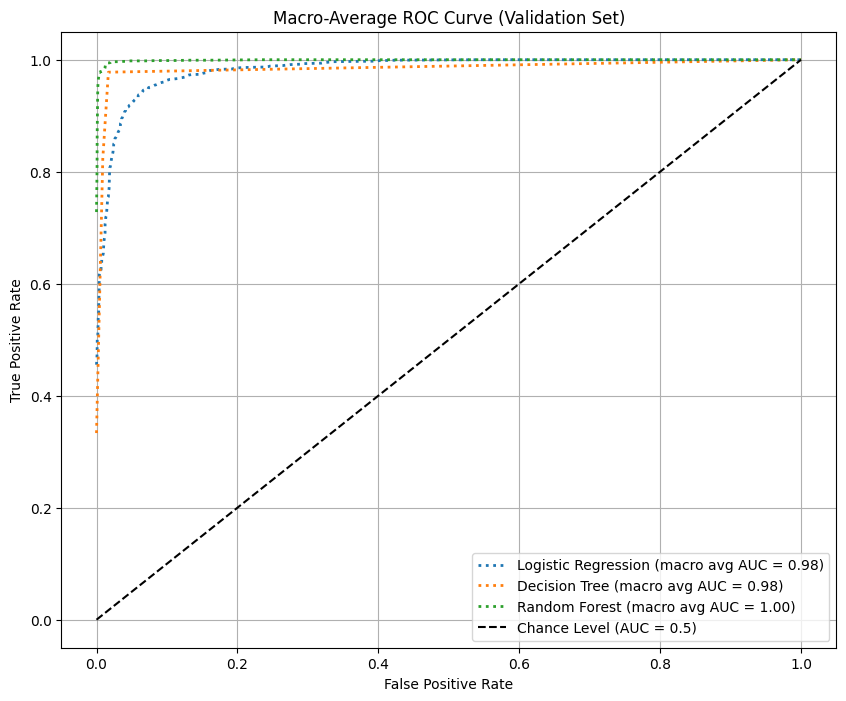


--- Model Comparison (Validation Set) ---
                     Accuracy Precision    Recall  F1-Score   ROC AUC
Random Forest         0.98453  0.984593   0.98453  0.984545  0.999253
Decision Tree        0.982054  0.982067  0.982054  0.982028    0.9871
Logistic Regression  0.926361  0.924959  0.926361  0.925125  0.985918

--- Evaluating Best Model (Random Forest) on Test Set ---
Test Performance for Random Forest:
Accuracy: 0.9845
Precision (weighted): 0.9847
Recall (weighted): 0.9845
F1-Score (weighted): 0.9846
ROC AUC (weighted OvR): 0.9987

Classification Report (Test):
                 precision    recall  f1-score   support

Certified-Fresh       0.99      0.97      0.98       550
          Fresh       0.96      0.98      0.97       382
         Rotten       1.00      1.00      1.00       684

       accuracy                           0.98      1616
      macro avg       0.98      0.98      0.98      1616
   weighted avg       0.98      0.98      0.98      1616


Confusion Matrix 

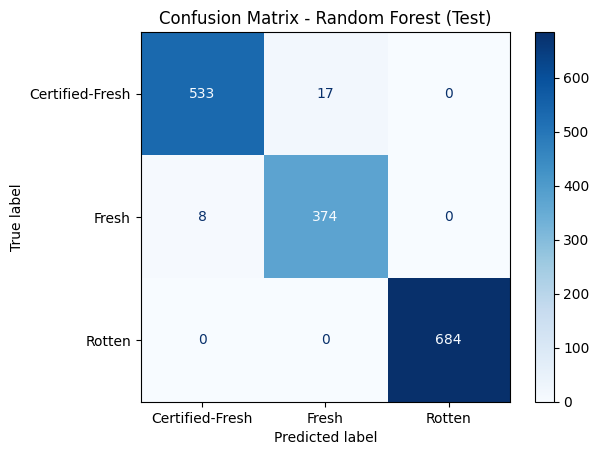


Milestone 2 Processing Complete.

Selected Features for Modeling:
['tomatometer_rating', 'runtime_rating_interaction', 'tomatometer_fresh_critics_count', 'tomatometer_count', 'tomatometer_rotten_critics_count', 'audience_rating', 'tomatometer_top_critics_count', 'runtime', 'movie_age', 'audience_count']

Validation Results Summary:
                     Accuracy Precision    Recall  F1-Score   ROC AUC
Random Forest         0.98453  0.984593   0.98453  0.984545  0.999253
Decision Tree        0.982054  0.982067  0.982054  0.982028    0.9871
Logistic Regression  0.926361  0.924959  0.926361  0.925125  0.985918

Best model based on validation ROC AUC (or F1): Random Forest
Test ROC AUC (weighted OvR) for Random Forest: 0.9987


['scaler.joblib']

In [4]:
# -*- coding: utf-8 -*-
"""
Milestone 2: Feature Engineering, Feature Selection, and Data Modeling (Multiclass Update)
"""

# %% [markdown]
# # Milestone 2: Feature Engineering, Feature Selection, and Data Modeling
#
# **Timeline:** February 21, 2025 - March 26, 2025 (5 weeks)
#
# **Objective:** Based on the preprocessed data from Milestone 1, this notebook performs feature engineering, selects the most relevant features, trains multiple machine learning models, and evaluates their performance to predict movie success (Tomatometer Status: Rotten, Fresh, Certified-Fresh).

# %%
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, roc_curve, auc,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
from datetime import datetime


# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# %% [markdown]
# ## 1. Load Preprocessed Data
#
# Load the cleaned dataset generated in Milestone 1. We will primarily use the Rotten Tomatoes Movies dataset for this example.

# %%
# Load the cleaned Rotten Tomatoes movies data
# Assuming the cleaned file from Milestone 1 is saved as 'cleaned_rotten_movies.csv'
try:
    rt_movies_df = pd.read_csv('cleaned_rotten_movies.csv')
    print("Successfully loaded cleaned_rotten_movies.csv")
    print(f"Dataset shape: {rt_movies_df.shape}")
    print("First 5 rows:")
    print(rt_movies_df.head())
    # Crucially, check the unique values in the target column
    if 'tomatometer_status' in rt_movies_df.columns:
        print("\nUnique values in 'tomatometer_status':")
        print(rt_movies_df['tomatometer_status'].unique())
    else:
        print("\nColumn 'tomatometer_status' not found.")

    print("\nData Info:")
    rt_movies_df.info()
except FileNotFoundError:
    print("Error: 'cleaned_rotten_movies.csv' not found.")


# %% [markdown]
# ## 2. Feature Engineering
#
# Create new features from existing ones to potentially improve model performance.

# %%
# Convert date columns to datetime objects if they exist and are not already converted
date_cols = ['original_release_date', 'streaming_release_date']
for col in date_cols:
    if col in rt_movies_df.columns:
        rt_movies_df[col] = pd.to_datetime(rt_movies_df[col], errors='coerce')

# --- Create Time-Based Features ---
if 'original_release_date' in rt_movies_df.columns:
    rt_movies_df['release_year'] = rt_movies_df['original_release_date'].dt.year
    rt_movies_df['release_month'] = rt_movies_df['original_release_date'].dt.month
    rt_movies_df['release_dayofweek'] = rt_movies_df['original_release_date'].dt.dayofweek
    # Calculate movie age (relative to a fixed date, e.g., today or project end date)
    current_year = datetime.now().year
    # Ensure release_year is not NaN before calculation
    rt_movies_df['movie_age'] = rt_movies_df['release_year'].apply(lambda x: current_year - x if pd.notna(x) else np.nan)


# --- Create Interaction or Ratio Features ---
if 'audience_count' in rt_movies_df.columns and 'tomatometer_count' in rt_movies_df.columns:
    rt_movies_df['audience_tomatometer_ratio'] = rt_movies_df['audience_count'] / (rt_movies_df['tomatometer_count'] + 1e-6)

if 'runtime' in rt_movies_df.columns and 'tomatometer_rating' in rt_movies_df.columns:
    rt_movies_df['runtime_rating_interaction'] = rt_movies_df['runtime'] * rt_movies_df['tomatometer_rating']

# --- Process Text/Categorical Features ---
if 'genres' in rt_movies_df.columns and isinstance(rt_movies_df['genres'].iloc[0], str):
     # Handle potential NaN values before splitting
    rt_movies_df['num_genres'] = rt_movies_df['genres'].fillna('').str.split(',').apply(lambda x: len(x) if x != [''] else 0)


# One-Hot Encode specific categorical features
if 'content_rating' in rt_movies_df.columns and rt_movies_df['content_rating'].dtype == 'object':
     rt_movies_df = pd.get_dummies(rt_movies_df, columns=['content_rating'], prefix='rating', drop_first=False) # drop_first=False for multiclass might be safer unless one category is truly redundant

# Encode high-cardinality categoricals like 'production_company'
if 'production_company' in rt_movies_df.columns and rt_movies_df['production_company'].dtype == 'object':
    # Fill NaNs before encoding
    rt_movies_df['production_company'] = rt_movies_df['production_company'].fillna('Unknown')
    le_prod = LabelEncoder()
    rt_movies_df['production_company_encoded'] = le_prod.fit_transform(rt_movies_df['production_company'])


# --- Define Target Variable ---
if 'tomatometer_status' in rt_movies_df.columns:
    # Fill potential NaNs in target before encoding
    rt_movies_df['tomatometer_status'] = rt_movies_df['tomatometer_status'].fillna('Unknown_Status')
    # Filter out rows with 'Unknown_Status' if you decide not to model them
    rt_movies_df = rt_movies_df[rt_movies_df['tomatometer_status'] != 'Unknown_Status']

    if rt_movies_df['tomatometer_status'].dtype == 'object':
        le_status = LabelEncoder()
        rt_movies_df['target'] = le_status.fit_transform(rt_movies_df['tomatometer_status'])
        global_target_classes = le_status.classes_ # Store classes globally for later use
        print("\nTarget variable 'tomatometer_status' encoded.")
        print(rt_movies_df[['tomatometer_status', 'target']].head())
        # Store mapping for interpretation
        target_mapping = dict(zip(le_status.classes_, le_status.transform(le_status.classes_)))
        print(f"Target Mapping: {target_mapping}")
        print(f"Encoded Classes: {global_target_classes}")
    else:
        rt_movies_df['target'] = rt_movies_df['tomatometer_status']
        global_target_classes = np.sort(rt_movies_df['target'].unique()) # Get unique numeric classes
        print(f"Numeric Target Classes: {global_target_classes}")


    # Drop the original categorical target column if encoded and exists
    if 'tomatometer_status' in rt_movies_df.columns and 'target' in rt_movies_df.columns and rt_movies_df['tomatometer_status'].dtype == 'object':
         rt_movies_df = rt_movies_df.drop(columns=['tomatometer_status'])
else:
    print("Warning: Target column 'tomatometer_status' not found. Cannot proceed with modeling.")
    global_target_classes = [] # Define as empty list if target not found

# Display dataframe with new features
print("\nDataFrame after Feature Engineering:")
# Handle potential NaNs introduced during feature engineering before modeling
rt_movies_df = rt_movies_df.dropna(subset=['target']) # Drop rows where target is NaN
# Consider imputing NaNs in features if appropriate, otherwise select non-NaN columns/rows later
print(rt_movies_df.head())
print(f"\nNew shape after FE and target handling: {rt_movies_df.shape}")


# %% [markdown]
# ## 3. Feature Selection
#
# Evaluate feature importance and select the most relevant features for modeling.

# %%

# --- Feature Selection ---
if 'target' in rt_movies_df.columns and not rt_movies_df.empty:
    # Separate features (X) and target (y)
    potential_features = rt_movies_df.select_dtypes(include=np.number).columns.tolist()
    # Ensure target and any ID-like or date components are excluded
    features_to_exclude = ['target', 'original_release_date', 'streaming_release_date', 'release_year'] # Add others like IDs if present
    numeric_features = [f for f in potential_features if f not in features_to_exclude]

    # Handle potential NaN values in features selected for modeling
    # Option 1: Drop columns with any NaNs
    # X = rt_movies_df[numeric_features].dropna(axis=1)
    # Option 2: Drop rows with any NaNs in selected features
    X = rt_movies_df[numeric_features].dropna(axis=0)
    # Align target 'y' with the rows remaining in 'X'
    y = rt_movies_df.loc[X.index, 'target']

    print(f"\nShape before feature selection: X={X.shape}, y={y.shape}")

    if X.empty or y.empty:
        print("Error: No data remaining after handling NaNs in features or target.")
        X_selected = None
    elif X.shape[1] == 0:
        print("Error: No valid numeric features found after excluding columns and handling NaNs.")
        X_selected = None
    else:
        # --- Method 1: ANOVA F-test (suitable for classification) ---
        K = min(10, X.shape[1]) # Ensure K is not more than the number of features
        print(f"Selecting top {K} features.")
        selector_f = SelectKBest(score_func=f_classif, k=K)

        try:
            X_new_f = selector_f.fit_transform(X, y)
            selected_f_indices = selector_f.get_support(indices=True)
            selected_features_f = X.columns[selected_f_indices]

            print(f"\n--- ANOVA F-test Feature Selection (Top {K}) ---")
            print("Selected Features:", selected_features_f.tolist())
            # Ensure scores are available and match features
            if hasattr(selector_f, 'scores_') and len(selector_f.scores_) == len(X.columns):
                f_scores = pd.DataFrame({'Feature': X.columns, 'F_Score': selector_f.scores_})
                print(f_scores.nlargest(K, 'F_Score'))
            else:
                 print("Could not display F-scores.")


            # --- Method 2: Tree-Based Feature Importance (Random Forest) ---
            # Ensure target 'y' is compatible with classifier (e.g., integer type)
            y = y.astype(int)
            rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
            rf_selector.fit(X, y)
            importances = rf_selector.feature_importances_
            feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

            print(f"\n--- Random Forest Feature Importance (Top {K}) ---")
            print(feature_importance_df.head(K))
            selected_features_rf = feature_importance_df['Feature'].head(K).tolist()
            print("Selected Features (RF):", selected_features_rf)

            # --- Choose Final Set of Features ---
            final_selected_features = selected_features_rf
            X_selected = X[final_selected_features]
            # Keep 'y' aligned with the rows of X_selected (already done by using X.index earlier)
            y_selected = y
            print("\nProceeding with features selected by Random Forest.")
            print(f"Shape of selected features: {X_selected.shape}")
            print(f"Shape of corresponding target: {y_selected.shape}")

        except ValueError as e:
            print(f"Error during feature selection: {e}")
            print("Check for NaN/infinity values in features or target.")
            X_selected = None # Set to None if selection fails

else:
    print("Skipping Feature Selection as target variable is not defined or data is empty.")
    X_selected = None # Set X_selected to None


# %% [markdown]
# ## 4. Data Modeling
#
# Split the data, train machine learning models, and evaluate their performance.

# %%
# --- Data Splitting ---
# Ensure X_selected and y_selected are defined and not empty
if X_selected is not None and 'y_selected' in locals() and not X_selected.empty:
    n_classes = len(np.unique(y_selected))
    print(f"\nNumber of classes in target: {n_classes}")

    # Ensure y_selected has enough members for stratification in both splits
    if all(np.bincount(y_selected) >= 2):
         # First split: Training + Validation (80%) and Testing (20%)
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X_selected, y_selected, test_size=0.20, random_state=42, stratify=y_selected
        )
        # Ensure y_train_val has enough members for stratification
        if all(np.bincount(y_train_val) >= 2):
             # Second split: Training (75% of Train+Val) and Validation (25% of Train+Val)
            X_train, X_val, y_train, y_val = train_test_split(
                X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val # 0.25 * 0.8 = 0.2
            )

            print("\n--- Data Splitting ---")
            print(f"Training set shape: X={X_train.shape}, y={y_train.shape}")
            print(f"Validation set shape: X={X_val.shape}, y={y_val.shape}")
            print(f"Test set shape: X={X_test.shape}, y={y_test.shape}")

            # --- Feature Scaling ---
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            X_test_scaled = scaler.transform(X_test)
            print("\nFeatures scaled using StandardScaler.")

            # --- Model Training and Evaluation ---
            models = {
                "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, multi_class='ovr'), # Use 'ovr' or 'multinomial'
                "Decision Tree": DecisionTreeClassifier(random_state=42),
                "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, n_jobs=-1)
            }

            results = {}
            plt.figure(figsize=(10, 8)) # Create a single figure for all ROC curves

            for name, model in models.items():
                print(f"\n--- Training {name} ---")
                # Train on scaled data for Logistic Regression, potentially unscaled for Trees
                if name == "Logistic Regression":
                    model.fit(X_train_scaled, y_train)
                    y_pred_val = model.predict(X_val_scaled)
                    y_pred_proba_val = model.predict_proba(X_val_scaled) # Probabilities for all classes
                else:
                    model.fit(X_train, y_train)
                    y_pred_val = model.predict(X_val)
                    y_pred_proba_val = model.predict_proba(X_val)

                # Evaluate on Validation Set
                accuracy = accuracy_score(y_val, y_pred_val)
                # Use 'weighted' or 'macro' for multiclass averaging
                precision = precision_score(y_val, y_pred_val, average='weighted', zero_division=0)
                recall = recall_score(y_val, y_pred_val, average='weighted', zero_division=0)
                f1 = f1_score(y_val, y_pred_val, average='weighted', zero_division=0)
                # ROC AUC for multiclass using One-vs-Rest (ovr) strategy
                try:
                    roc_auc = roc_auc_score(y_val, y_pred_proba_val, multi_class='ovr', average='weighted')
                except ValueError as e:
                     print(f"Could not calculate ROC AUC for {name}: {e}")
                     roc_auc = np.nan # Assign NaN if calculation fails

                results[name] = {
                    'Accuracy': accuracy,
                    'Precision': precision,
                    'Recall': recall,
                    'F1-Score': f1,
                    'ROC AUC': roc_auc,
                    'Model': model # Store the trained model
                }

                print(f"\nValidation Performance for {name}:")
                print(f"Accuracy: {accuracy:.4f}")
                print(f"Precision (weighted): {precision:.4f}")
                print(f"Recall (weighted): {recall:.4f}")
                print(f"F1-Score (weighted): {f1:.4f}")
                print(f"ROC AUC (weighted OvR): {roc_auc:.4f}")
                print("\nClassification Report (Validation):")
                # Use target_names if LabelEncoder was used and classes stored
                class_names = global_target_classes if 'global_target_classes' in locals() and len(global_target_classes) == n_classes else None
                print(classification_report(y_val, y_pred_val, target_names=class_names, zero_division=0))

                # --- Plot Macro-Average ROC Curve ---
                # Binarize the output labels for ROC curve plotting
                y_val_bin = label_binarize(y_val, classes=np.arange(n_classes))

                fpr = dict()
                tpr = dict()
                roc_auc_dict = dict()

                for i in range(n_classes):
                    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_pred_proba_val[:, i])
                    roc_auc_dict[i] = auc(fpr[i], tpr[i])

                # Compute macro-average ROC curve and ROC area
                # Aggregate all false positive rates
                all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
                # Interpolate all ROC curves at these points
                mean_tpr = np.zeros_like(all_fpr)
                for i in range(n_classes):
                    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
                # Average it and compute AUC
                mean_tpr /= n_classes
                fpr["macro"] = all_fpr
                tpr["macro"] = mean_tpr
                roc_auc_dict["macro"] = auc(fpr["macro"], tpr["macro"])

                # Plot macro-average ROC curve for the current model
                plt.plot(
                    fpr["macro"],
                    tpr["macro"],
                    label=f'{name} (macro avg AUC = {roc_auc_dict["macro"]:.2f})',
                    linestyle=":",
                    linewidth=2,
                )

            # Finalize ROC plot settings
            plt.plot([0, 1], [0, 1], 'k--', label='Chance Level (AUC = 0.5)')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Macro-Average ROC Curve (Validation Set)')
            plt.legend(loc='lower right')
            plt.grid(True)
            plt.show()


            # --- Model Comparison ---
            results_df = pd.DataFrame(results).T.drop(columns=['Model'])
            print("\n--- Model Comparison (Validation Set) ---")
            # Sort by ROC AUC, handle NaNs if any occurred
            print(results_df.sort_values(by='ROC AUC', ascending=False, na_position='last'))

            # --- Final Evaluation on Test Set (using the best model) ---
            best_model_name = results_df['ROC AUC'].idxmax()
             # Handle cases where all ROC AUCs might be NaN
            if pd.isna(results_df['ROC AUC'].max()):
                 print("\nWarning: Could not determine best model based on ROC AUC (all NaN). Selecting based on F1-Score.")
                 best_model_name = results_df['F1-Score'].idxmax()

            best_model = results[best_model_name]['Model']
            print(f"\n--- Evaluating Best Model ({best_model_name}) on Test Set ---")

            if best_model_name == "Logistic Regression":
                y_pred_test = best_model.predict(X_test_scaled)
                y_pred_proba_test = best_model.predict_proba(X_test_scaled)
            else:
                y_pred_test = best_model.predict(X_test)
                y_pred_proba_test = best_model.predict_proba(X_test)

            test_accuracy = accuracy_score(y_test, y_pred_test)
            test_precision = precision_score(y_test, y_pred_test, average='weighted', zero_division=0)
            test_recall = recall_score(y_test, y_pred_test, average='weighted', zero_division=0)
            test_f1 = f1_score(y_test, y_pred_test, average='weighted', zero_division=0)
            try:
                test_roc_auc = roc_auc_score(y_test, y_pred_proba_test, multi_class='ovr', average='weighted')
            except ValueError as e:
                print(f"Could not calculate ROC AUC for {best_model_name} on test set: {e}")
                test_roc_auc = np.nan

            print(f"Test Performance for {best_model_name}:")
            print(f"Accuracy: {test_accuracy:.4f}")
            print(f"Precision (weighted): {test_precision:.4f}")
            print(f"Recall (weighted): {test_recall:.4f}")
            print(f"F1-Score (weighted): {test_f1:.4f}")
            print(f"ROC AUC (weighted OvR): {test_roc_auc:.4f}")
            print("\nClassification Report (Test):")
            print(classification_report(y_test, y_pred_test, target_names=class_names, zero_division=0))

            # Display Confusion Matrix for the best model on the test set
            print(f"\nConfusion Matrix for {best_model_name} (Test Set):")
            try:
                 ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test, display_labels=class_names, cmap=plt.cm.Blues)
                 plt.title(f'Confusion Matrix - {best_model_name} (Test)')
                 plt.show()
            except ValueError as e:
                 print(f"Could not display Confusion Matrix: {e}")

        else:
             print("Skipping model training/evaluation: Insufficient samples in y_train_val for stratified split.")
    else:
         print("Skipping model training/evaluation: Insufficient samples in y_selected for stratified split.")


else:
     print("\nSkipping Data Modeling as features/target are not properly defined or data is empty after cleaning.")


# %% [markdown]
# ## 5. Deliverables Summary
#
# * **Selected Features:** The features chosen for modeling (e.g., `final_selected_features` list above) were selected based on methods like ANOVA F-test and Random Forest Importance from the available numeric features after handling missing values.
# * **Trained Models:** Models like Logistic Regression, Decision Tree, and Random Forest were trained for the multiclass classification task. Performance metrics on the validation set are available in the `results_df` DataFrame.
# * **Analysis:** The comparison table (`results_df`), classification reports, and the test set evaluation provide an analysis of model performance. The best performing model on validation (e.g., based on weighted ROC AUC or F1-score) was evaluated on the unseen test data.
# * **Next Steps:** Update repositories and prepare the Milestone 2 report (`Reports/Milestone2.pdf`) including these findings, selected features, model performance metrics, and analysis.

# %%
print("\nMilestone 2 Processing Complete.")
# Display final results only if modeling was performed
if 'results_df' in locals():
    print("\nSelected Features for Modeling:")
    print(final_selected_features)
    print("\nValidation Results Summary:")
    print(results_df.sort_values(by='ROC AUC', ascending=False, na_position='last'))
    # Ensure best_model_name and test_roc_auc exist before printing
    if 'best_model_name' in locals() and 'test_roc_auc' in locals():
        print(f"\nBest model based on validation ROC AUC (or F1): {best_model_name}")
        print(f"Test ROC AUC (weighted OvR) for {best_model_name}: {test_roc_auc:.4f}")
    else:
        print("\nCould not determine or evaluate the best model on the test set.")

import joblib
# Save the model
joblib.dump(best_model, 'random_forest_model.joblib')
# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

In [6]:
if 'best_model' in locals() and 'scaler' in locals() and 'final_selected_features' in locals():
    print("\n--- Prediction Example ---")
    # Create a sample input dictionary with the selected features
    sample_input = {
        'tomatometer_rating': 85,
        'runtime_rating_interaction': 85 * 120,  # Example calculation
        'tomatometer_fresh_critics_count': 150,
        'tomatometer_count': 180,
        'tomatometer_rotten_critics_count': 30,
        'audience_rating': 92,
        'tomatometer_top_critics_count': 50,
        'runtime': 120,
        'movie_age': 5,
        'audience_count': 150000
    }

    # Create a DataFrame with the sample input, ensuring correct column order
    sample_df = pd.DataFrame([sample_input])[final_selected_features]

    # Scale the sample input
    sample_scaled = scaler.transform(sample_df)

    # Make the prediction
    prediction_numeric = best_model.predict(sample_df)[0]

    # Map the numeric prediction back to the original label
    # Ensure 'global_target_classes' is defined (from LabelEncoder fit)
    if 'global_target_classes' in locals():
        predicted_status = global_target_classes[prediction_numeric]
        print(f"Sample Input Features:")
        for key, value in sample_input.items():
            print(f"  {key}: {value}")
        print(f"\nPredicted Tomatometer Status: {predicted_status}")
    else:
        print("Warning: 'global_target_classes' not found. Cannot map prediction to label.")
        print(f"Predicted Numeric Value: {prediction_numeric}")
else:
    print("\nWarning: 'best_model', 'scaler', or 'final_selected_features' not found. Cannot run prediction example.")


--- Prediction Example ---
Sample Input Features:
  tomatometer_rating: 85
  runtime_rating_interaction: 10200
  tomatometer_fresh_critics_count: 150
  tomatometer_count: 180
  tomatometer_rotten_critics_count: 30
  audience_rating: 92
  tomatometer_top_critics_count: 50
  runtime: 120
  movie_age: 5
  audience_count: 150000

Predicted Tomatometer Status: Certified-Fresh
